# Channel Flow (Steady) DEMO code

This notebook demonstrates solving steady-state channel flow (uniform inlet) using Physics-Informed Neural Networks (PINNs).

In [1]:
import deepflow as df
df.manual_seed(69)

## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [2]:
rectangle = df.Geometry.rectangle([0,1], [0,1])

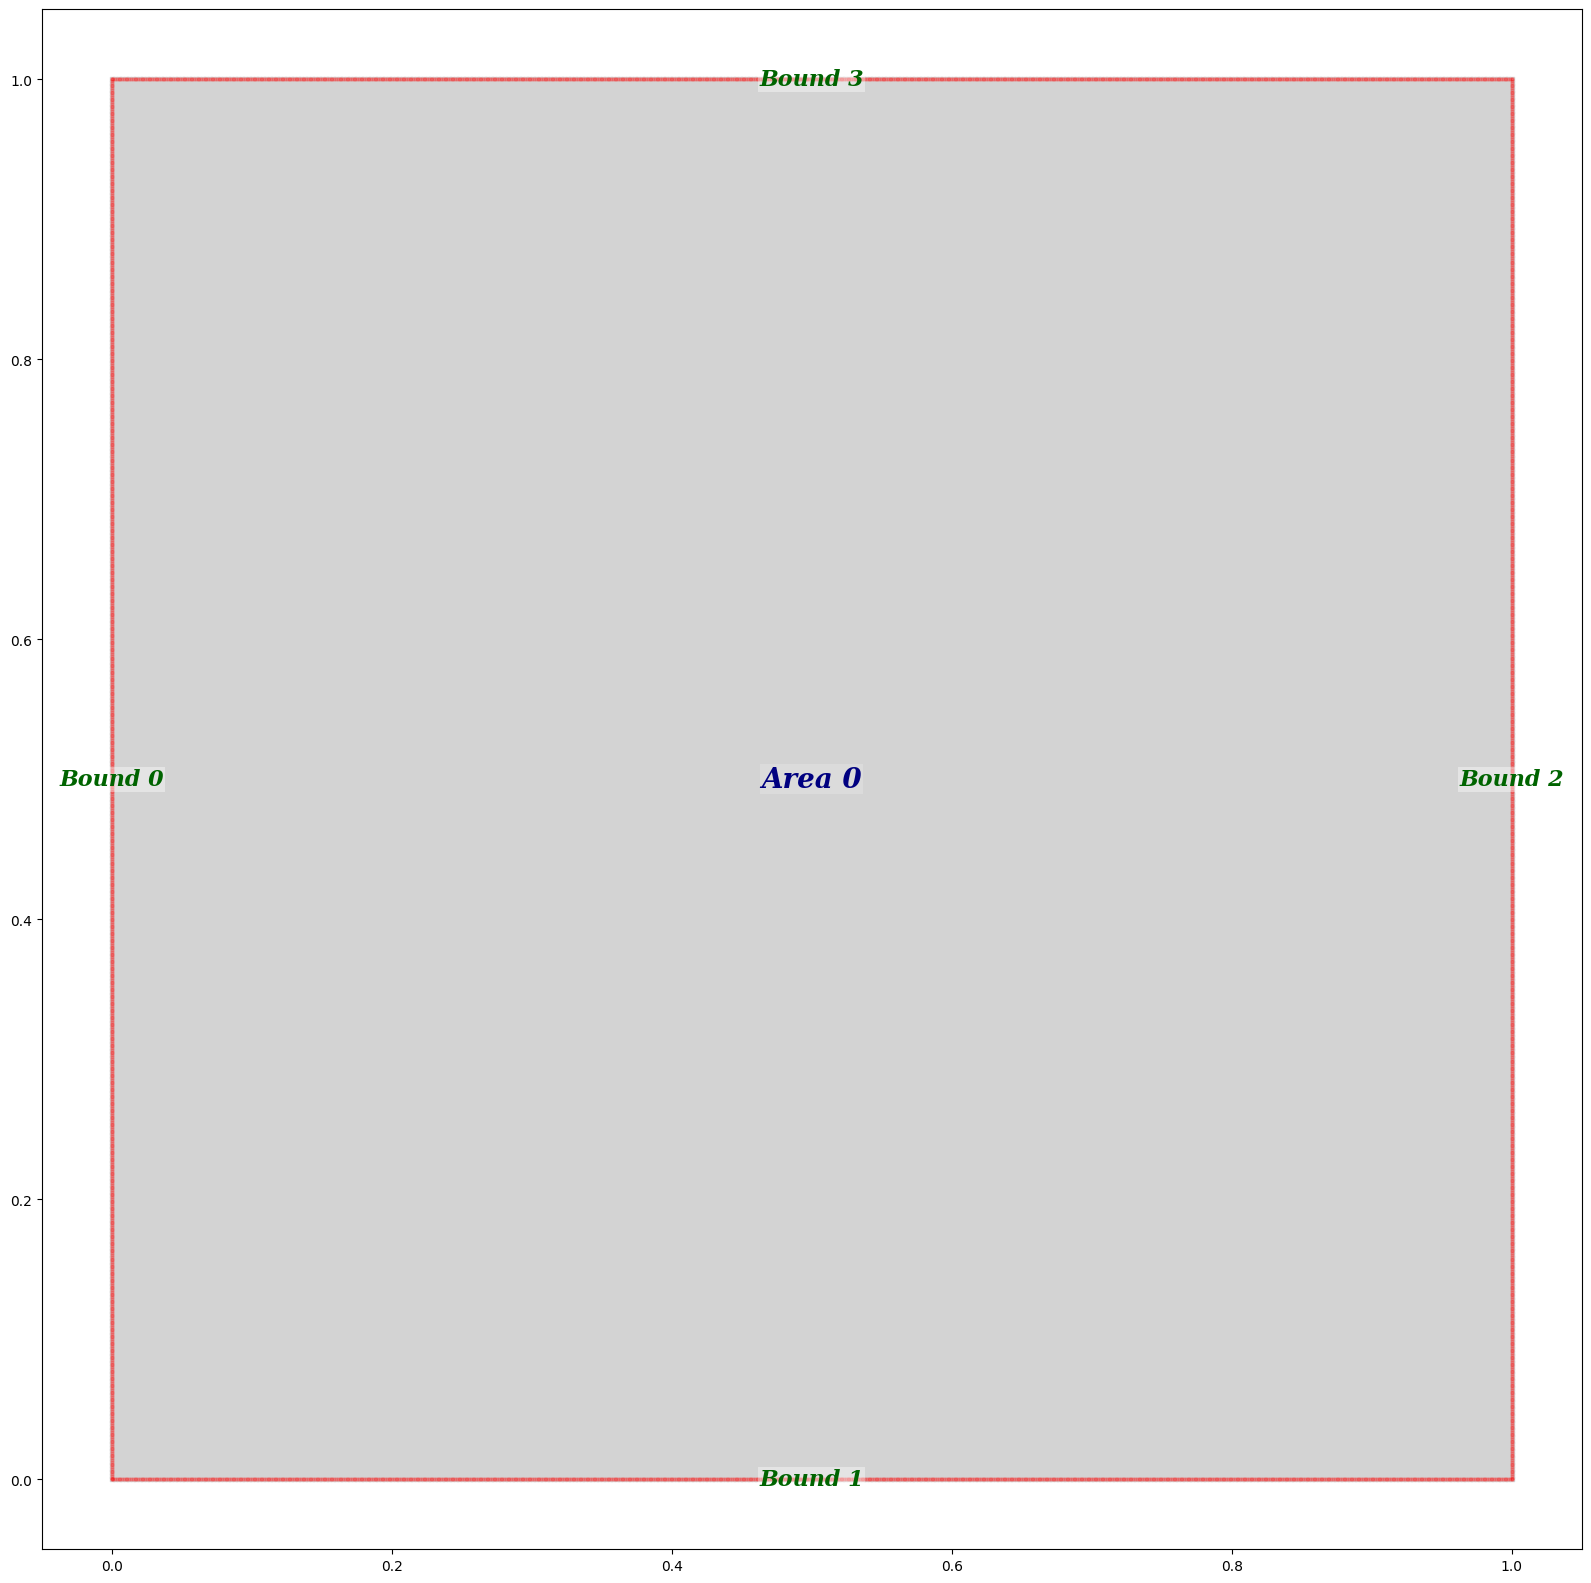

In [3]:
domain = df.domain(rectangle.bound_list, rectangle)
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

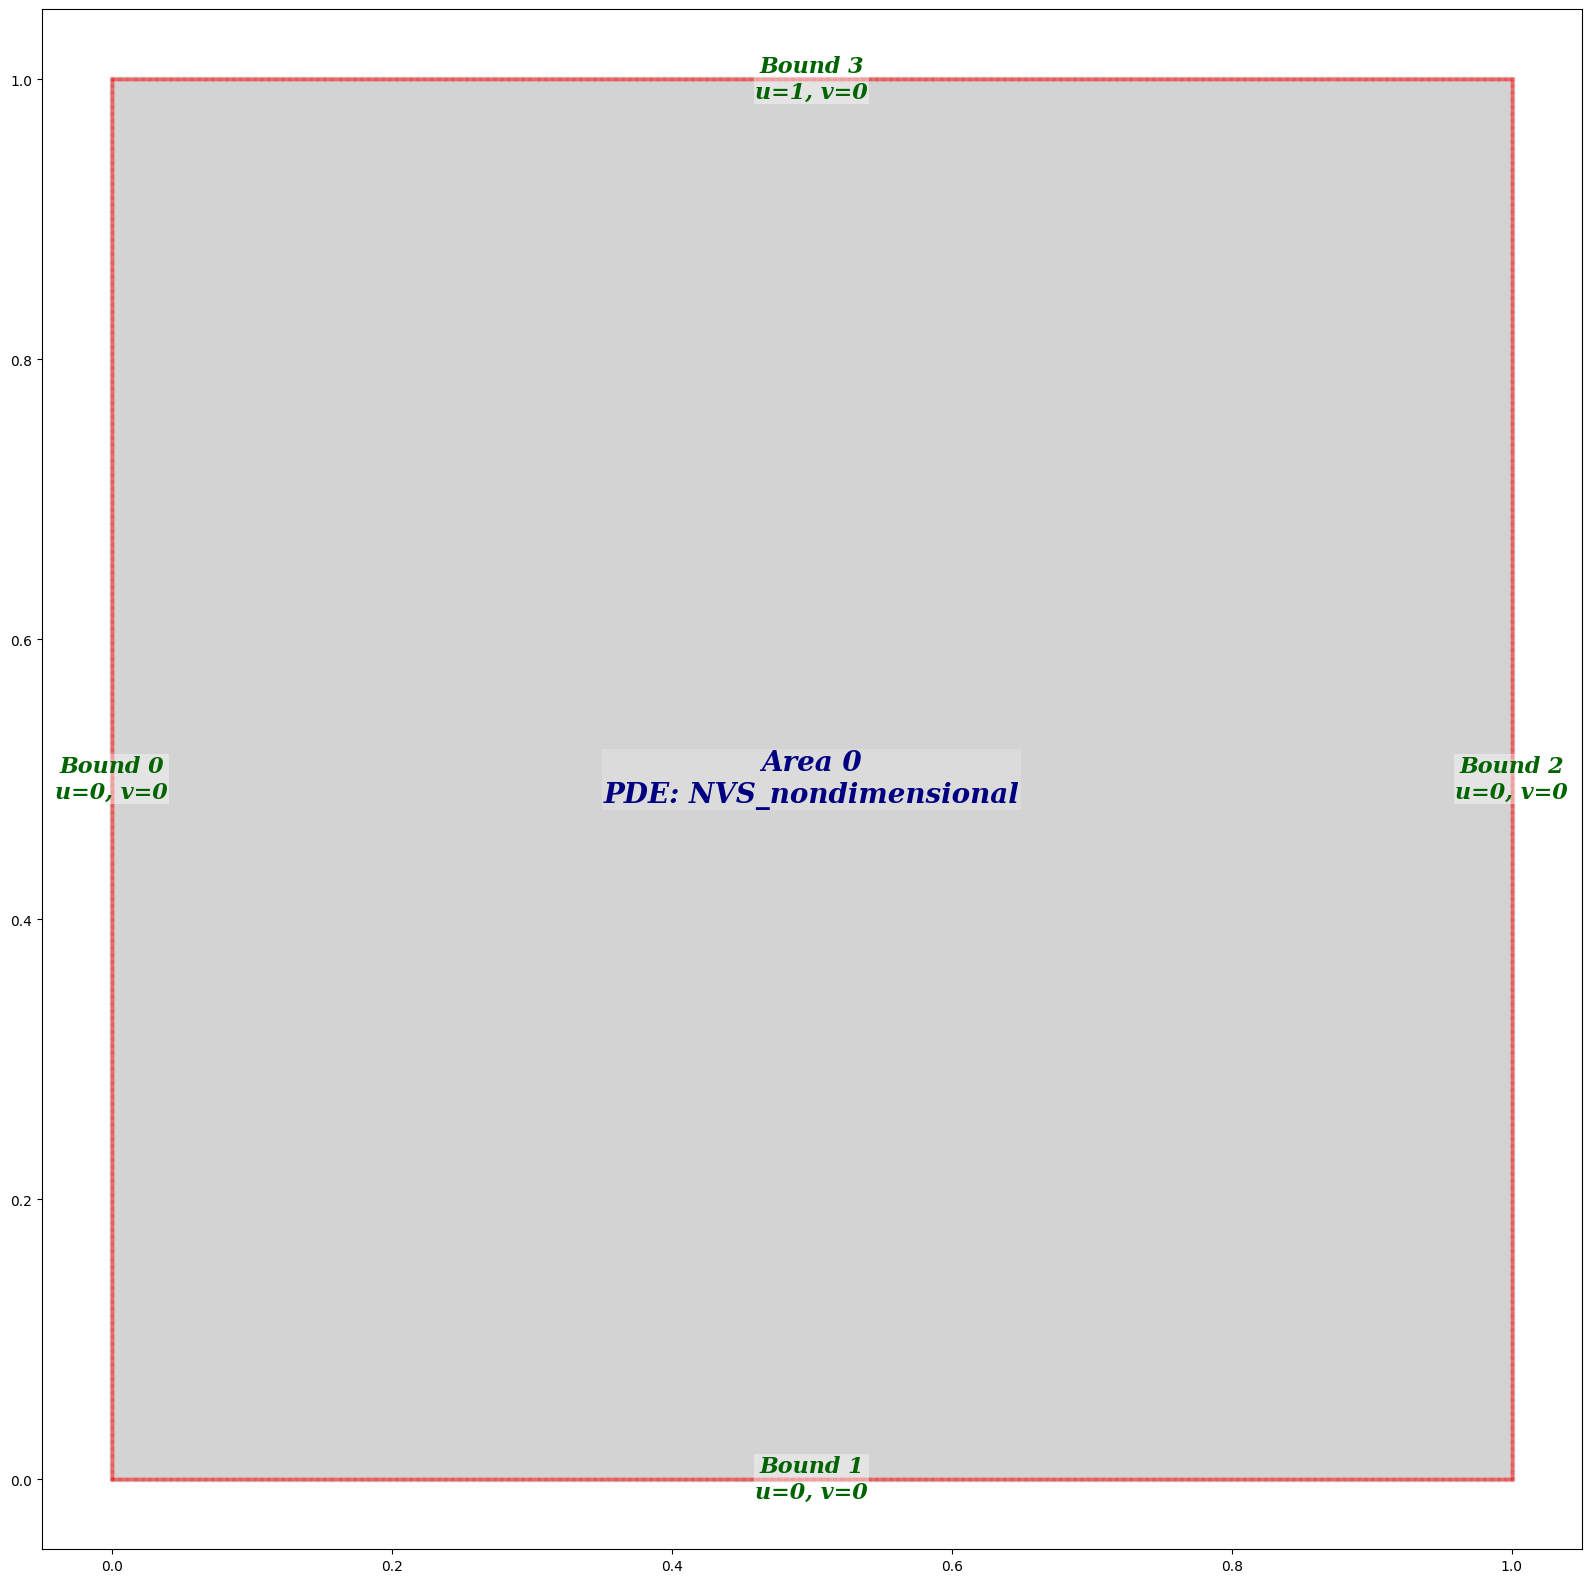

In [4]:
domain.bound_list[0].define_bc({'u':0,'v':0})
domain.bound_list[1].define_bc({'u':0,'v':0})
domain.bound_list[2].define_bc({'u':0,'v':0})
domain.bound_list[3].define_bc({'u':1,'v':0})
domain.area_list[0].define_pde(df.NVS_nondimensional(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup()


Sample initial points for training. Required if using Residual-based Adaptive Refinement (RAR).

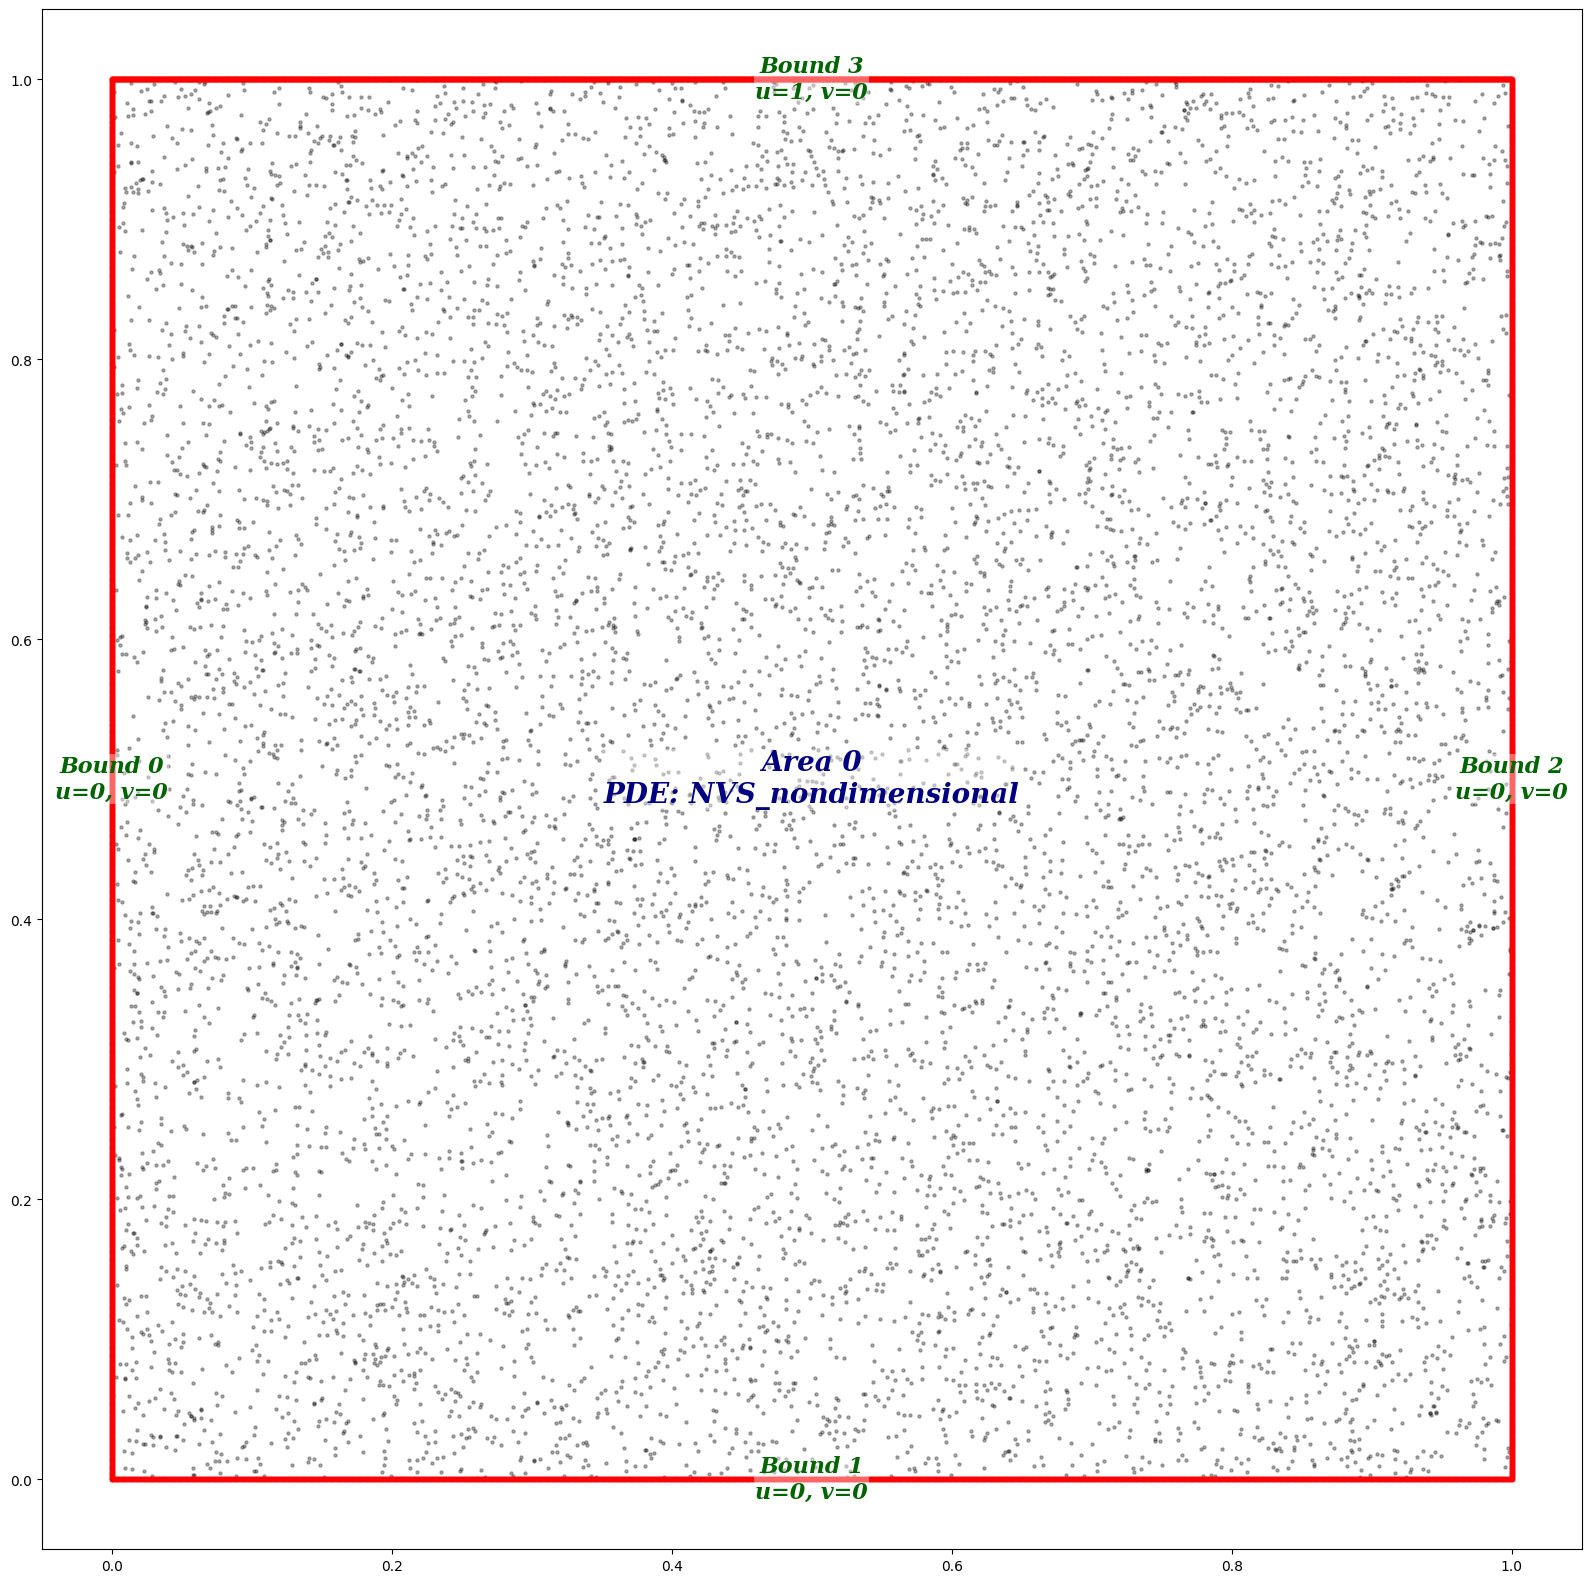

In [5]:
domain.sampling_uniform(bound_sampling_res=[2000, 2000, 2000, 4000])
domain.sampling_random_r(area_sampling_res=[10000])
domain.show_coordinates(display_conditions=True)

## 3. Train the PINN model
Initialize a PINN with specified width and depth.

In [6]:
model0 = df.PINN(width=50, length=5)
model0.apply_hard_constraints(domain.bound_list)

Design how to compute loss from boundary conditions and PDE residuals

In [7]:
# Define the loss calculation function
N = 0
def calc_loss(model):
    global N
    N += 1

    # # Add collocation points using RAR scheme
    # if N % 1000==0:
    #     print(f'sampling RAR at {N}')
    #     domain.sampling_RAR([2, 2, 2, 2], [50], model, [10, 10, 10, 10], [250]) #topk: 20% of candidate points
    
    # # Add collocation points using RAR scheme
    # if N % 250==0 and N>600:
    #     print(f'sampling RAR at {N}')
    #     domain.sampling_random_r(bound_sampling_res=[0, 0, 0, 200],area_sampling_res=[4000]) #topk: 20% of candidate points
    #     #domain.sampling_RAR([2, 20, 2, 20], [400], model, [100, 200, 100, 200], [40000]) #topk: 1% of candidate points

    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        bc_loss += bc.calc_loss(model)

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model)

    # Total Loss
    total_loss = bc_loss + 100*pde_loss # weight bc_loss more

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss} # MUST RETURN IN THIS FORMAT

Train the model using Adam for initial training (faster convergence).

In [8]:
# Train the model
model1, model1best = model0.train_adam(
    calc_loss=calc_loss,
    learning_rate=0.001,
    epochs=1000,
    print_every=200,
    threshold_loss=0.01,
    has_scheduler=True
)

Training interrupted by user.


UnboundLocalError: cannot access local variable 'best_model' where it is not associated with a value

Refine the model using LBFGS for higher precision.

In [ ]:
# Define a stable loss function for LBFGS (no RAR sampling)
def calc_loss_lbfgs(model):
    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        bc_loss += bc.calc_loss(model)

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model)

    # Total Loss
    total_loss = bc_loss + 1*pde_loss 

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss}

In [ ]:
# Train the model
model2 = model1best.train_lbfgs(
    calc_loss=calc_loss_lbfgs,
    epochs=500,
    print_every=50,
    threshold_loss=0.001)

epoch 2001, total_loss: 0.07812, bc_loss: 0.06707, pde_loss: 0.01105
epoch 2051, total_loss: 0.03627, bc_loss: 0.02956, pde_loss: 0.00671
epoch 2101, total_loss: 0.01445, bc_loss: 0.01080, pde_loss: 0.00365
epoch 2151, total_loss: 0.00767, bc_loss: 0.00602, pde_loss: 0.00165
epoch 2201, total_loss: 0.00452, bc_loss: 0.00340, pde_loss: 0.00112
epoch 2251, total_loss: 0.00293, bc_loss: 0.00217, pde_loss: 0.00076
epoch 2301, total_loss: 0.00205, bc_loss: 0.00143, pde_loss: 0.00063
epoch 2351, total_loss: 0.00153, bc_loss: 0.00112, pde_loss: 0.00041
epoch 2401, total_loss: 0.00128, bc_loss: 0.00100, pde_loss: 0.00028
epoch 2451, total_loss: 0.00109, bc_loss: 0.00086, pde_loss: 0.00024


Save or Load the model for later use

In [ ]:
import pickle
# Save model with pickle
with open("model2.pkl", "wb") as f:
    pickle.dump(model2, f)

#Load model back
with open("model2.pkl", "rb") as f:
    model2 = pickle.load(f)

Show the final sampled points used in training

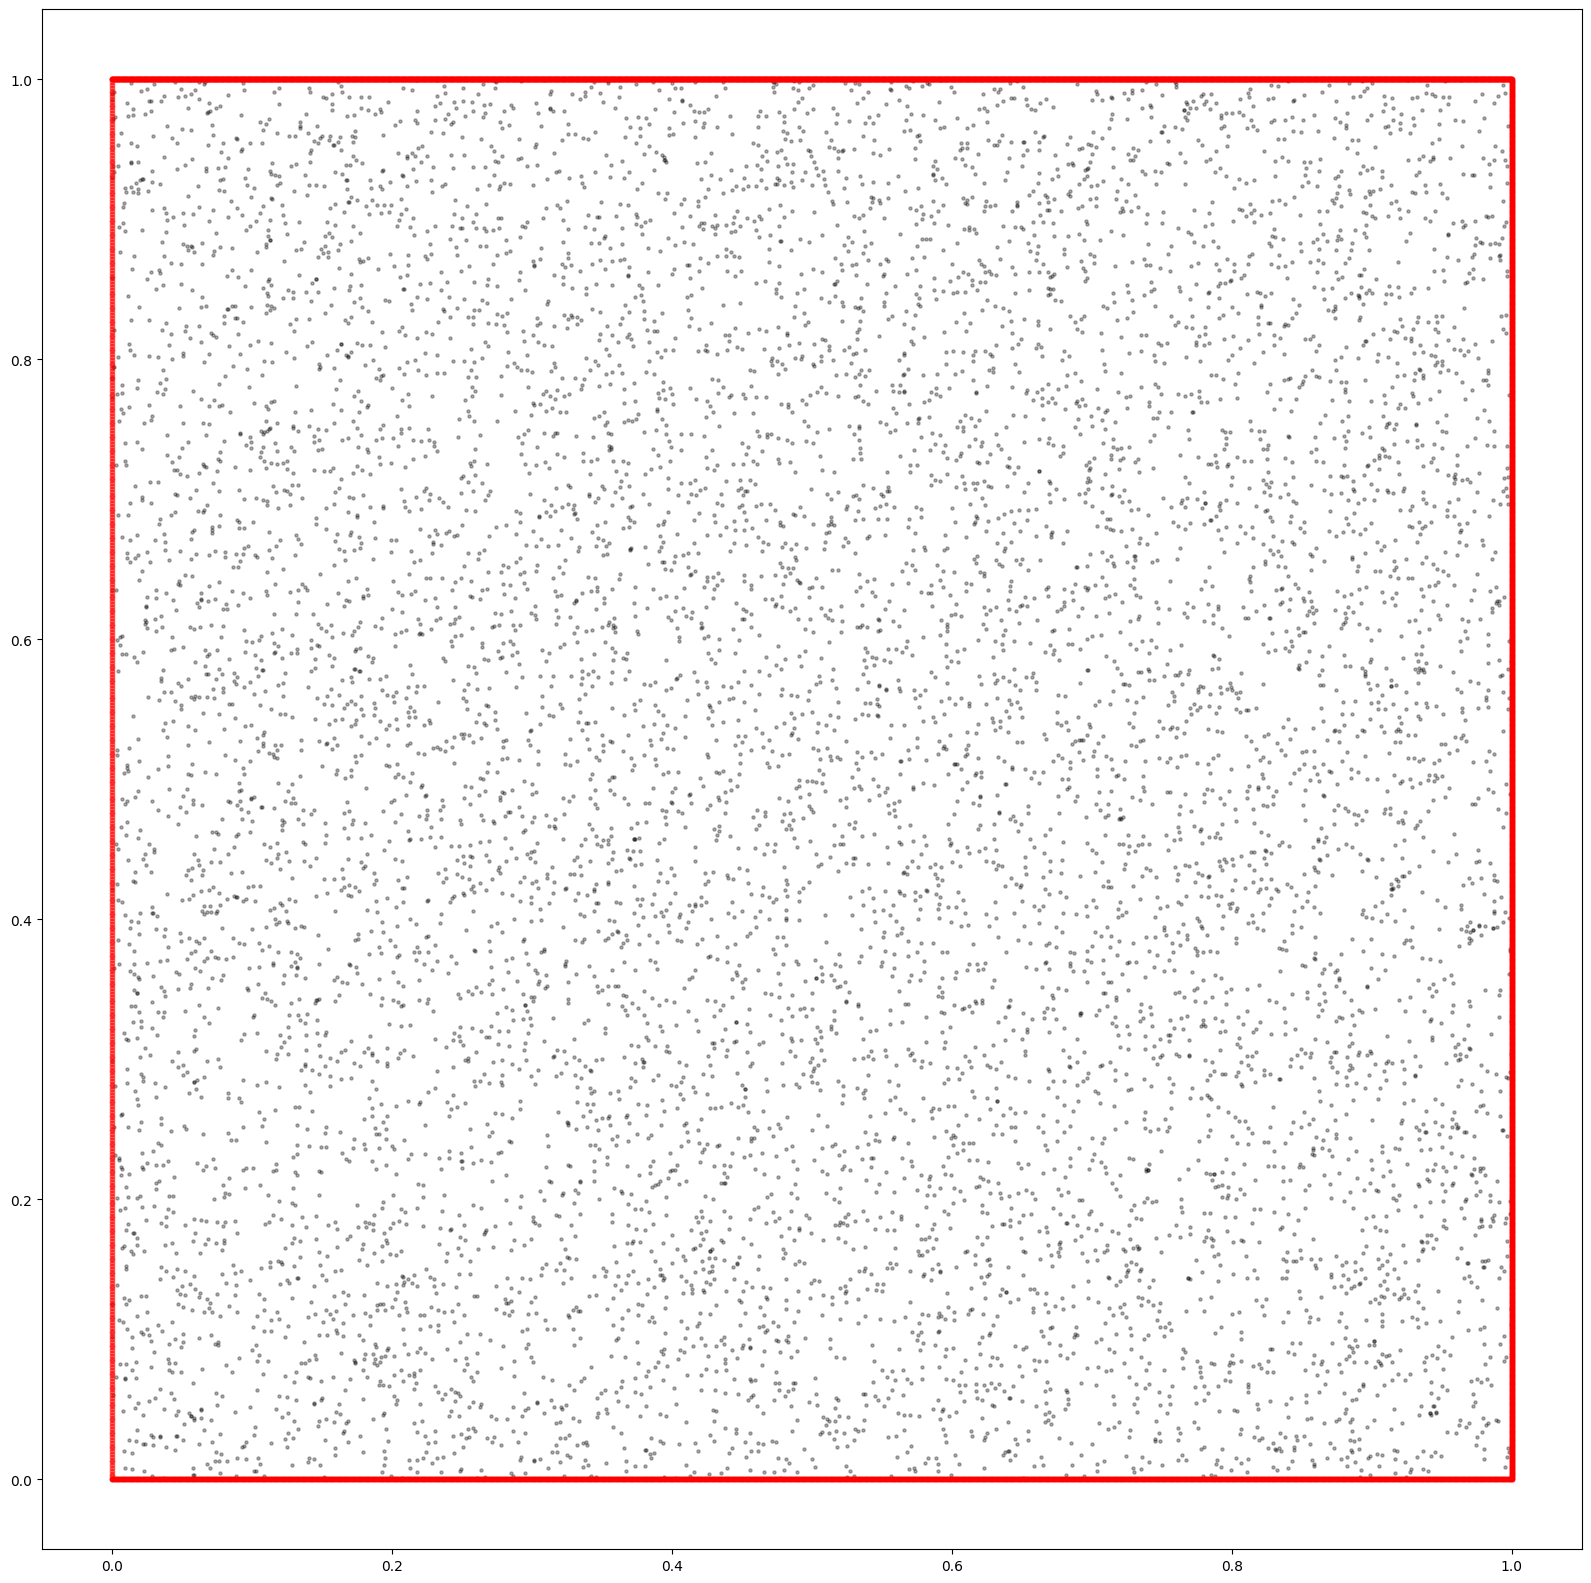

number of bound : 4
        ['0: 500', '1: 2000', '2: 2000', '3: 4000']
        , number of area : 1
        ['0: 10000']


In [ ]:
domain.show_coordinates()
print(domain)

## 4. Visualization

### 4.1 Visualize area

In [ ]:
from deepflow import Physics, Geometry
area = Geometry.rectangle([0,1], [0,1])
area.define_pde(Physics.NVS_nondimensional(U=0.0001, L=1, mu=0.001, rho=1000))

In [ ]:
import numpy as np
# Create object for evaluation (Need Model and Geometry)
area_visual = area.evaluate(model2)
# Sampling uniform points
area_visual.sampling_area(500, 500)
area_visual["PDE residual"] = np.clip(area_visual["PDE residual"], 0, 1)

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'u_x', 'v_x', 'p_x', 'u_y', 'v_y', 'p_y', 'u_xx', 'v_xx', 'u_yy', 'v_yy', 'PDE residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss')


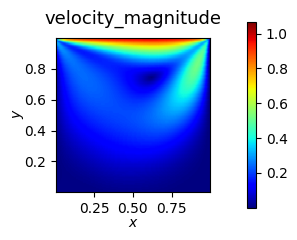

In [ ]:
cmap_dict = {
    'velocity_magnitude': 'jet',
}
colorplot_area_2d = area_visual.plot_data_on_geometry(cmap_dict, s=0.7)
colorplot_area_2d.savefig('colorplot_area_2d.png')

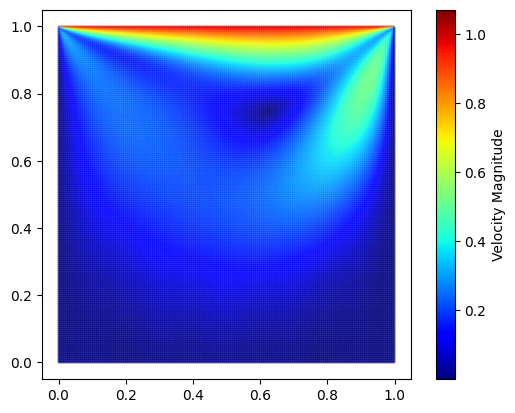

In [ ]:
from matplotlib import pyplot as plt
data = area_visual['velocity_magnitude']
plt.scatter(area_visual["x"], area_visual["y"], c=area_visual["velocity_magnitude"], s=0.02, cmap='jet')
plt.colorbar(label='Velocity Magnitude')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('velocity_magnitude_scatter_final.png')

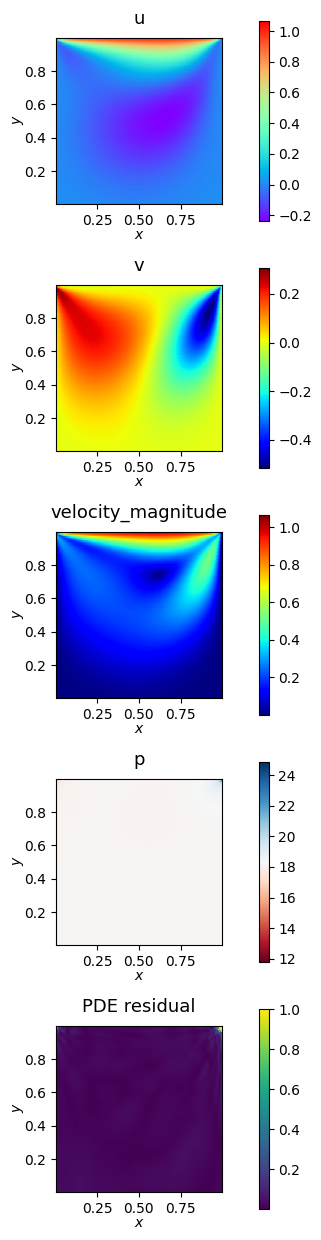

In [ ]:
cmap_dict = {
    'u':'rainbow',
    'v':'jet',
    'velocity_magnitude': 'jet',
    'p':'RdBu',
    'PDE residual': 'viridis'
}
colorplot_area_2d = area_visual.plot_data_on_geometry(cmap_dict, s=0.7)
colorplot_area_2d.savefig('colorplot_area_2d.png')

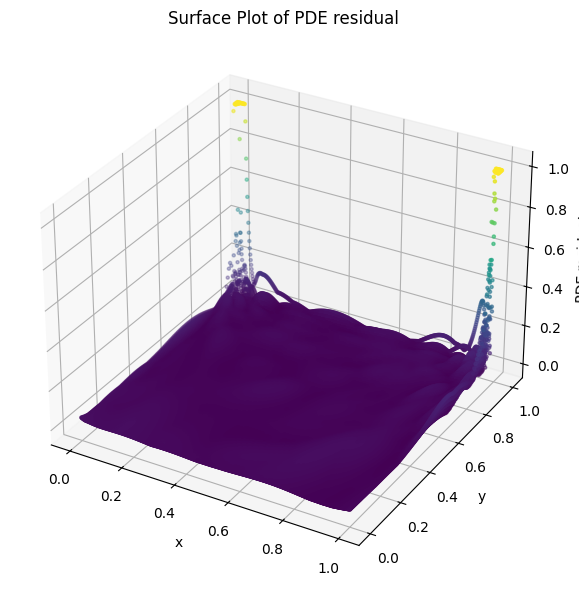

In [ ]:
residual_plot_3d = area_visual.plot_data('PDE residual')
residual_plot_3d.savefig('residual_plot_3d.png')

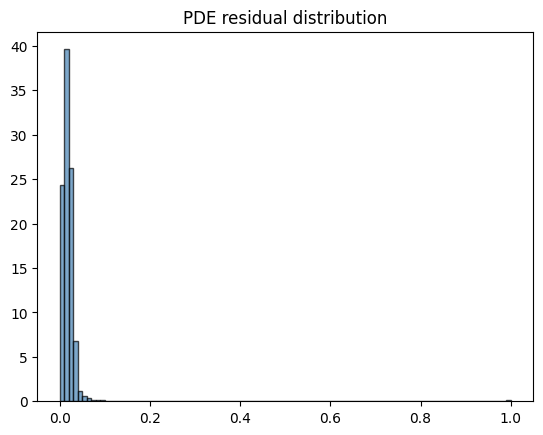

In [ ]:
residual_destribution = area_visual.plot_data_distribution('PDE residual', bins=100)

### 4.2 Visualize bound

In [ ]:
# Create object for evaluation (Need Model and Geometry)
bound_visual = domain.bound_list[0].evaluate(model2)
# Sampling uniform points
bound_visual.sampling_line(500)

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'BC residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss')


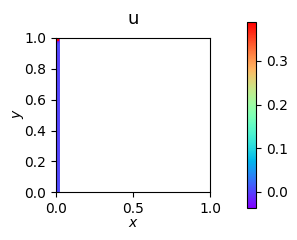

In [ ]:
cmap_dict = {'u':'rainbow'}
colorplot_bound = bound_visual.plot_data_on_geometry(cmap_dict, range_x=[0,1], range_y=[0,1], s=10)
colorplot_bound.savefig('colorplot_bound.png')

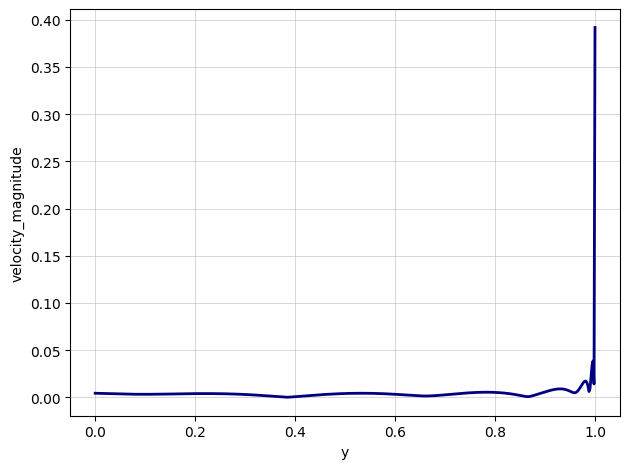

In [ ]:
velocity_plot_outlet = bound_visual.plot_data({'velocity_magnitude':'viridis'}, axis='y')
velocity_plot_outlet.savefig('velocity_plot_outlet.png')

## 4.3 Visualize Neural Network data

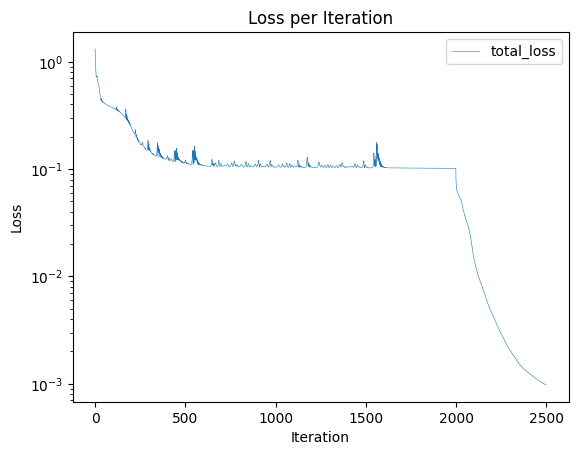

In [ ]:
loss_history = bound_visual.plot_loss_curve(log_scale=True, linewidth=0.4, num=1)
loss_history.savefig('loss_history.png')

### 4.4 Export data

In [ ]:
# display available options
print(bound_visual.data_dict.keys())

dict_keys(['u', 'v', 'p', 'velocity_magnitude', 'BC residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss'])


In [ ]:
# store the x,y,velocity_magnitude data
x_data = bound_visual.data_dict['x']
y_data = bound_visual.data_dict['y']
velocity_magnitude_data = bound_visual.data_dict['velocity_magnitude']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, velocity_magnitude_data))
np.savetxt('outlet_velocity_profile.txt', array)